<a href="https://colab.research.google.com/github/chloepython/colabtest/blob/main/Copy_of_ikea_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# % pip uninstall tensorflow-gpu
# % pip install tensorflow-gpu==2.0.0b1

In [ ]:
% pip install scikit-learn

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

import imgaug.augmenters as iaa
import imgaug as ia


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# input image_file_path, make target.
from glob import glob
import os
file_path = []
dir = glob('/content/drive/My Drive/row_data_cabinet/finished_0209_aug_max/*')
classes= {}
for d in dir:
  files = glob(d + '/*.*')
  file_path += files

  classes[os.path.split(d)[-1]] = len(files)
print(len(classes))
print(classes)
print(len(file_path))

#####
class_map = { c:i for i, c in enumerate(classes)}
trans = {i:c for c, i in class_map.items()}
CLASSES_SIZE = len(class_map)
print(class_map)
print(trans)

24
{'parts_screw_circle': 338, 'parts_bolt': 338, 'object_people': 335, 'parts_screw': 338, 'parts_doorknob': 338, 'connector_circle': 338, 'connector_triangle': 338, 'object_glass': 338, 'wood_board': 338, 'parts_pad': 338, 'woods': 338, 'parts_connector': 338, 'object_hand': 338, 'parts_screw_special': 338, 'parts_slide': 338, 'parts_cover': 338, 'parts_support': 338, 'action_x': 338, 'action_arrow': 338, 'parts_sticker': 338, 'parts_washer': 338, 'parts_nail': 338, 'tool': 338, 'parts_iron': 338}
8109
{'parts_screw_circle': 0, 'parts_bolt': 1, 'object_people': 2, 'parts_screw': 3, 'parts_doorknob': 4, 'connector_circle': 5, 'connector_triangle': 6, 'object_glass': 7, 'wood_board': 8, 'parts_pad': 9, 'woods': 10, 'parts_connector': 11, 'object_hand': 12, 'parts_screw_special': 13, 'parts_slide': 14, 'parts_cover': 15, 'parts_support': 16, 'action_x': 17, 'action_arrow': 18, 'parts_sticker': 19, 'parts_washer': 20, 'parts_nail': 21, 'tool': 22, 'parts_iron': 23}
{0: 'parts_screw_circl

In [ ]:
base = VGG16(include_top=True, weights=None, pooling='avg', classes=CLASSES_SIZE)
model = Model(inputs=base.input, outputs=base.output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

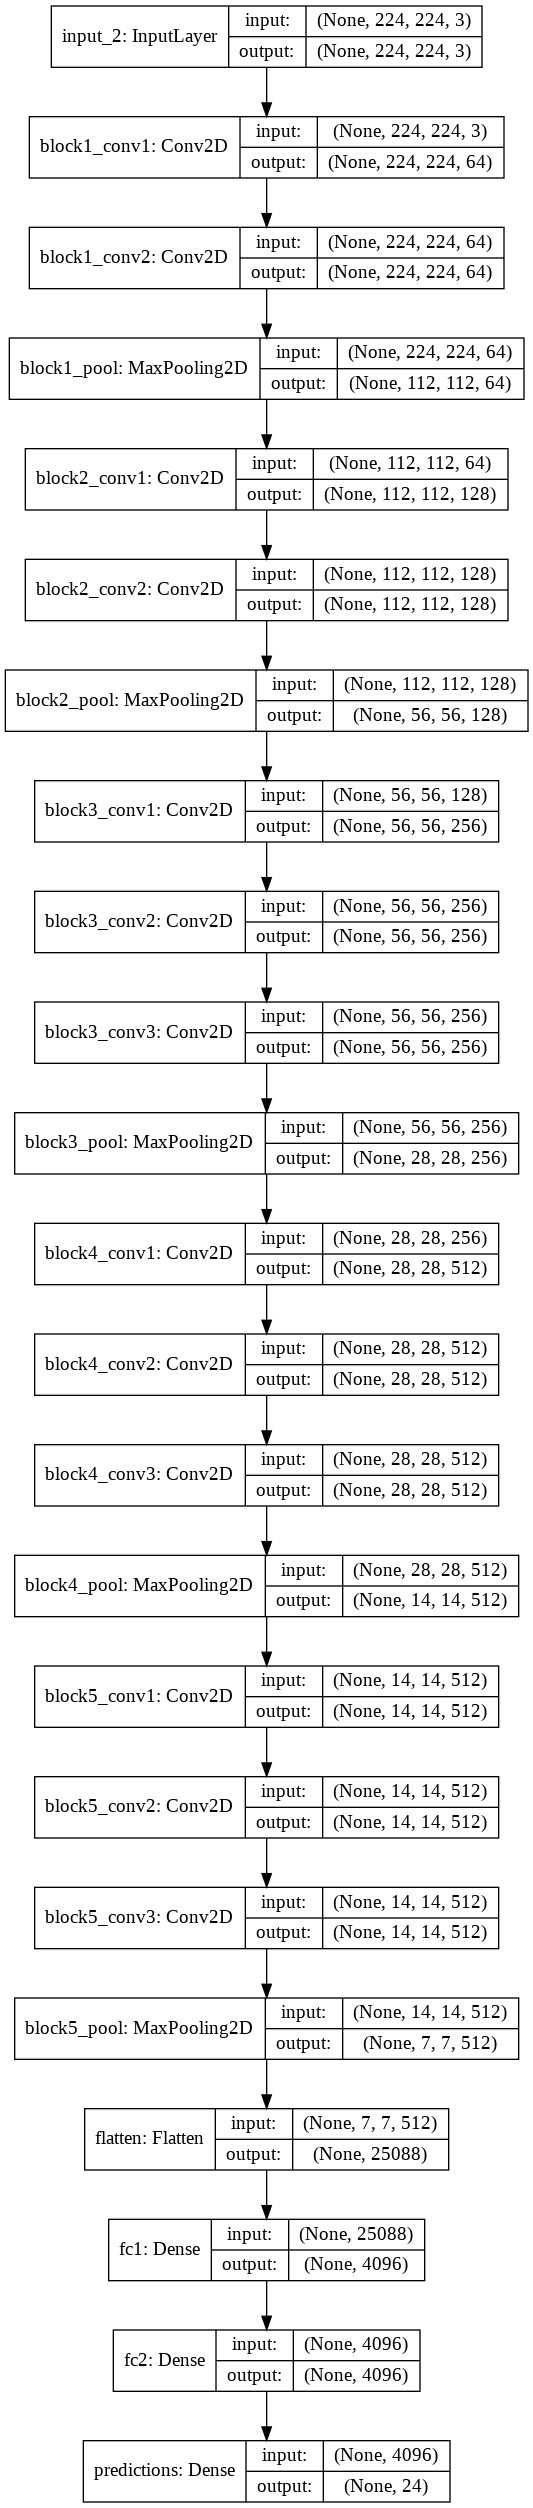

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='categorical_crossentropy',
                      metrics=['accuracy'],
                      optimizer='adam')

In [ ]:
# from sklearn.model_selection import train_test_split
train_path, test_path = train_test_split(file_path, test_size=0.2)

In [ ]:
# Generator.
def data_generator(data_paths, batch_size, num_classes):
    '''data generator for fit_generator'''
    # Class.
    class_map = {'parts_screw_circle': 0, 'parts_bolt': 1, 'object_people': 2, 'parts_screw': 3,
                 'parts_doorknob': 4, 'connector_circle': 5, 'connector_triangle': 6, 'object_glass': 7,
                 'wood_board': 8, 'parts_pad': 9, 'woods': 10, 'parts_connector': 11, 'object_hand': 12,
                 'parts_screw_special': 13, 'parts_slide': 14, 'parts_cover': 15, 'parts_support': 16,
                 'action_x': 17, 'action_arrow': 18, 'parts_sticker': 19, 'parts_washer': 20, 'parts_nail': 21,
                 'tool': 22, 'parts_iron': 23}

    n = len(data_paths)
    i = 0
    data_paths = data_paths
    while True:
        image_data = []
        class_data = []
        for b in range(batch_size):
            # Shuffle.
            if i==0:
                np.random.shuffle(data_paths)

            # Load image and preprocess.
            img_path = data_paths[i]
            # Augmentation. 要的話要用openCV, resize.
            img = load_img(img_path, color_mode='rgb', target_size=(224, 224), interpolation='bilinear')
            img = np.array(img)
            img_pre = preprocess_input(img.astype("float64"))
            image_data.append(img_pre)

            # Classes.
            cls = img_path.split('/')[-2]
            class_data.append(class_map[cls])

            i = (i+1) % n

        image_data = np.array(image_data)
        class_data = np.array(class_data)
        one_hot =  to_categorical(class_data, num_classes)
        yield image_data, one_hot

In [ ]:
# Callback.
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0, restore_best_weights=True)
checkpoint = ModelCheckpoint('ikea.h5',monitor='val_loss', save_best_only=True, save_weights_only=False, period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', period=3, factor=0.1)

In [ ]:
# batch_size=20, num_classes=76
BATCH_SZIE = 20
generator_train = data_generator(train_path, BATCH_SZIE, CLASSES_SIZE)
generator_test =  data_generator(test_path, BATCH_SZIE, CLASSES_SIZE)

In [ ]:
# a, b = next(generator_train)
# print(np.array(a).shape, np.array(b).shape)
# b[8]

In [ ]:
# aa, bb = next(generator_test)
# print(np.array(aa).shape, np.array(bb).shape)
# bb[8]

In [ ]:
# model.fit_generator.
model.fit_generator(generator_train,
                   epochs=20,
                   steps_per_epoch=len(train_path)// BATCH_SZIE,
                   validation_steps=len(test_path)// BATCH_SZIE,
                   callbacks=[early_stopping, checkpoint, reduce_lr],
                   validation_data=generator_test)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





324/324 [==============================] - 2819s 9s/step - loss: 15.3990 - acc: 0.0423 - val_loss: 15.5112 - val_acc: 0.0377
Epoch 2/20
324/324 [==============================] - 80s 248ms/step - loss: 15.4291 - acc: 0.0427 - val_loss: 15.5112 - val_acc: 0.0377
Epoch 3/20
324/324 [==============================] - 86s 266ms/step - loss: 15.4316 - acc: 0.0426 - val_loss: 15.5112 - val_acc: 0.0377
Epoch 4/20
324/324 [==============================] - 77s 238ms/step - loss: 15.4366 - acc: 0.0423 - val_loss: 15.5112 - val_acc: 0.0377
Epoch 5/20
324/324 [==============================] - 78s 240ms/step - loss: 15.4191 - acc: 0.0434 - val_loss: 15.5410 - val_acc: 0.0358
Epoch 6/20
324/324 [==============================] - 77s 238ms/step - loss: 15.4291 - acc: 0.0427 - val_loss: 15.4913 - val_acc: 0.0389
Epoch 7/20
324/324 [==============================] - 77s 239ms/step - loss: 

In [ ]:
# model.save('/content/drive/My Drive/row_data_cabinet/ikea_0208.h5')

In [ ]:
model.evaluate_generator(generator_test, steps=len(test_path)// BATCH_SZIE)

[15.491280414440014, 0.03888888974432592]

In [ ]:
# Load model.
from keras.models import load_model
new_model = load_model('ikea.h5')

In [ ]:
new_model.evaluate_generator(generator_test, steps=len(test_path)// BATCH_SZIE)

[15.511179241133325, 0.037654321594738666]

In [ ]:
# Load all data for predict and Confusion_matrix

val_image_data = []
val_class_data = []
for data_paths in test_path:
    # Load image and preprocess.
    img_path = data_paths
    # Augmentation. 要的話要用openCV, resize.
    img = load_img(img_path, color_mode='rgb', target_size=(224, 224), interpolation='bilinear')
    img = np.array(img)
    img_pre = preprocess_input(img.astype("float64"))
    val_image_data.append(img_pre)

    # Classes.
    cls = img_path.split('/')[-2]
    val_class_data.append(class_map[cls])

val_image_data = np.array(val_image_data)
val_class_data = np.array(val_class_data)
print(val_image_data.shape, val_class_data.shape)

(1622, 224, 224, 3) (1622,)


In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd

pre = new_model.predict(val_image_data)
pre = np.argmax(pre, axis=1) # Show the best prediction.
# confusion_matrix(y_true, y_pred)
i = [name+'(T)' for name in class_map]
c = [name+'(F)' for name in class_map]
df = pd.DataFrame(confusion_matrix(val_class_data, pre), index=i, columns=c)
df

,parts_screw_circle(F),parts_bolt(F),object_people(F),parts_screw(F),parts_doorknob(F),connector_circle(F),connector_triangle(F),object_glass(F),wood_board(F),parts_pad(F),woods(F),parts_connector(F),object_hand(F),parts_screw_special(F),parts_slide(F),parts_cover(F),parts_support(F),action_x(F),action_arrow(F),parts_sticker(F),parts_washer(F),parts_nail(F),tool(F),parts_iron(F)
parts_screw_circle(T),0,78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
parts_bolt(T),0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
object_people(T),0,76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
parts_screw(T),0,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
parts_doorknob(T),0,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
connector_circle(T),0,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
connector_triangle(T),0,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
object_glass(T),0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
wood_board(T),0,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
parts_pad(T),0,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Plot wrong pictures.
import matplotlib.pyplot as plt
idx = np.nonzero(pre != val_class_data)[0]

false_label = val_class_data[idx]
false_pre = pre[idx]
false_img = val_image_data[idx]

width = 10
height = len(idx) // width + 1
plt.figure(figsize=(50, 60))

false_collection = zip(false_label, false_pre, false_img)
# 得到每一個: (index, (false_label, pre, img))
for i, (l, p, img) in enumerate(false_collection):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[l], trans[p])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i